In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
import numpy as np
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [ ]:
def get_day_load_data(load_path):
    '''read csv data at load_path and return it in a numpy matrix'''
    data = pd.read_csv(load_path)
    date_ = load_path.split('/')[-1][:-4] # get date of '01-10-2017' format
    data['date'] = datetime.strptime(date_, "%d-%m-%Y").date()
    data['time'] += ':00'
    data['datetime'] = pd.to_timedelta(data['time'])
    data['hour'] = data['datetime'].dt.seconds // 3600 
    return data.to_numpy()

In [ ]:
def get_30min_wise_data(day_load_data):
    '''Returns time, day temp, humidity and load values for each 30mins in a numpy matrix'''
    data = []
    for i in range(0, 288, 6): # SLDC load data has time step of 5 mins, so total 24 * (60 // 5)
        load = day_load_data[i][1]
        day = day_load_data[i][2].weekday()
        
        try:
            humidity = 55
        except Exception as e:
            humidity = 50 # some dirt values in data
        try:
            temp = float(day_whether_data[i//6][0]) # i//6 because whether data is already in 30 min step size
        except Exception as err:
            temp = 28 # aiyvi
        data.append([i, day, temp, humidity, load])
    return np.asarray(data)

In [ ]:
def get_data(data_list, shuffle=True):
    '''Return data of all csv files in SLDC_Data/ folder in matrix form'''
    data = []
    for load_path in data_list:
        try:
            # whether_path = load_path.replace('SLDC_Data', 'Whether_Data')
            day_load_data = get_day_load_data(load_path)
            # day_whether_data = pd.read_csv(whether_path)
            day_data = get_30min_wise_data(day_load_data)
            data.append(day_data)
        except Exception as e:
            print(load_path, e)
    data = np.asarray(data) # (115, 48, 5)
    data = data.reshape(-1, 5) # (5520, 5)
    if shuffle: np.random.shuffle(data)
    return data

In [ ]:
# data preprocessing
data_list = glob.glob('/content/drive/MyDrive/SLDC_Data/*/*/*.csv')
train, test = train_test_split(data_list, test_size=0.1)
train_data = get_data(train)
X_train = train_data[:, :-1] # features
Y_train = train_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

/content/drive/MyDrive/SLDC_Data/2022/12/10-12-2022.csv index 144 is out of bounds for axis 0 with size 143
/content/drive/MyDrive/SLDC_Data/2022/12/01-12-2022.csv index 66 is out of bounds for axis 0 with size 65
/content/drive/MyDrive/SLDC_Data/2023/01/18-01-2023.csv index 240 is out of bounds for axis 0 with size 239
/content/drive/MyDrive/SLDC_Data/2023/02/24-02-2023.csv index 282 is out of bounds for axis 0 with size 282
/content/drive/MyDrive/SLDC_Data/2022/12/15-12-2022.csv index 216 is out of bounds for axis 0 with size 215
/content/drive/MyDrive/SLDC_Data/2022/10/06-10-2022.csv index 228 is out of bounds for axis 0 with size 228
/content/drive/MyDrive/SLDC_Data/2023/02/03-02-2023.csv index 168 is out of bounds for axis 0 with size 167
/content/drive/MyDrive/SLDC_Data/2022/10/09-10-2022.csv index 204 is out of bounds for axis 0 with size 204
/content/drive/MyDrive/SLDC_Data/2023/01/04-01-2023.csv index 252 is out of bounds for axis 0 with size 251
/content/drive/MyDrive/SLDC_Da

In [ ]:
X_train

array([[ 66.,   0.,  28.,  55.],
       [204.,   2.,  28.,  55.],
       [ 60.,   6.,  28.,  55.],
       ...,
       [126.,   3.,  28.,  55.],
       [ 66.,   2.,  28.,  55.],
       [114.,   3.,  28.,  55.]])

In [ ]:
# rescale the data to 0-1 values`
feature_scaler = MinMaxScaler(feature_range=(0, 1))
load_scaler = MinMaxScaler(feature_range=(0, 1)) # try StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
Y_train = load_scaler.fit_transform(Y_train)

In [ ]:
!pip install xgboost==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
from numpy import absolute

In [ ]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.087 (0.003)


In [ ]:
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
def predict(data):
    '''selects a date in data and plots the predicted curve using the trained model'''
    try:
        x = np.random.randint(len(data)) # to select a date in data data
        data_data = get_data([data[x]], shuffle=False)
        X_data = data_data[:, :-1] # features
        Y_data = data_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

        X_data = feature_scaler.fit_transform(X_data)
        Y_data = load_scaler.fit_transform(Y_data)

        preds = model.predict(X_data)
        # print(preds)
        preds = preds.reshape(-1, 1)
        preds = load_scaler.inverse_transform(preds)
        Y_ = load_scaler.inverse_transform(Y_data)

        plt.plot(range(len(Y_)), Y_)
        plt.plot(range(len(preds)), preds)
        plt.legend(['actual', 'pred'])
        plt.title(data[x])
        plt.show()
    except Exception as e:
        print('Err in data', e)

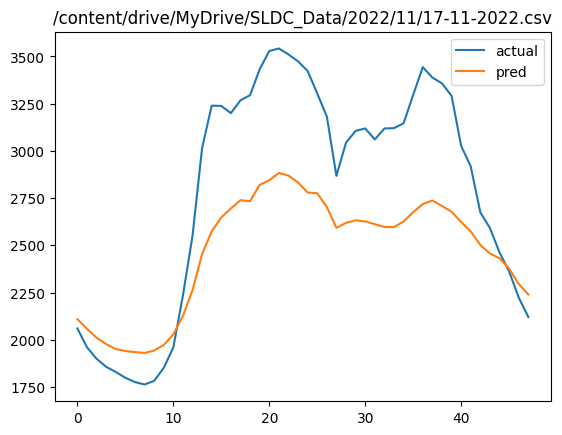

In [ ]:
# prediction on test data
predict(test)

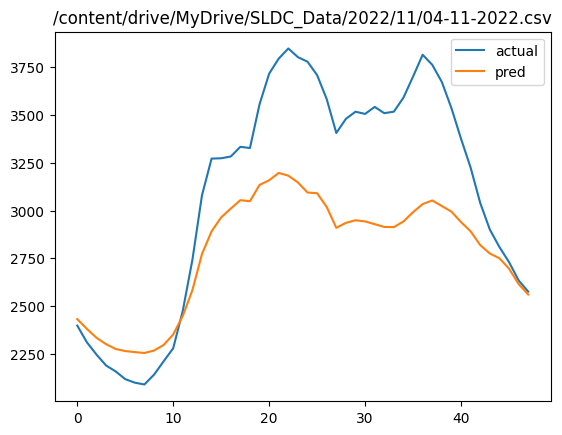

In [ ]:
# prediction on train data
predict(train)

1401 1451


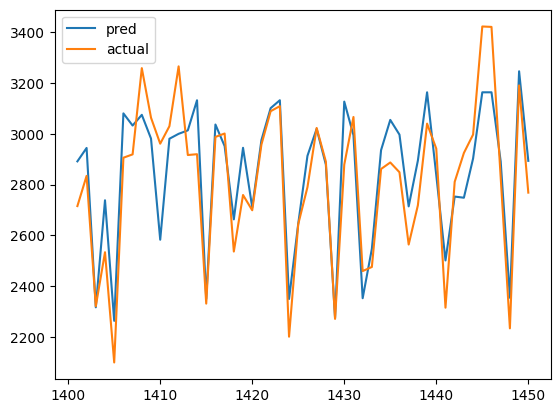

In [ ]:
# prediction on train data as a whole

preds = model.predict(X_train)
preds = preds.reshape(-1,1)
preds = load_scaler.inverse_transform(preds)
Y_ = load_scaler.inverse_transform(Y_train)

x = np.random.randint(len(preds))
x_max = 50
print(x,x+x_max)
plt.plot(range(x, x+x_max), preds[x:x+x_max])
plt.plot(range(x, x+x_max), Y_[x:x+x_max])
plt.legend(['pred', 'actual'])
plt.show()